<a href="https://colab.research.google.com/github/Gregtom3/vossen_ecal_ai/blob/main/notebooks/tutorial_1a_basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tutorial Overview

In this section, we showcase the basic machine learning approach to resolving the false photon problem at CLAS12. We follow along with the event data collected by the `hipo2tree.C` program in [the photon AI repo](https://github.com/Gregtom3/clas12_photon_classifier). The event data was collected using a Monte Carlo event generator with simulated detector readouts in Geant4. Particles are reconstructed using the Coatjava framework.

## Imports

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.5 MB/s eta 0:00:00


## Data loading
Here we use `pandas` to extract the photon CSV data from the GitHub.

In [6]:
# URL to the raw CSV file
url = "https://raw.githubusercontent.com/Gregtom3/vossen_ecal_ai/main/data/photon_data_simple.csv"

# Read the CSV into a DataFrame
df = pd.read_csv(url)
columns = list(df.columns)

# Display the data frame
display(df)

# Print the length of the dataframe and number of events
print("Total number of photons =",len(df))
print("Total number of events =",len(df['event'].unique()))


# Gather model inputs and outputs
input_columns = [col for col in columns if col not in ['event','y','truepid','trueparentpid','trueparentid']]
output_column = 'y'

X,y = df[input_columns],df[output_column]
event = df['event']

,event,truepid,trueparentpid,trueparentid,y,gE,gTheta,gPhi,gEpcal,gm2u,...,R_nh_0,R_nh_1,dE_nh_0,dE_nh_1,Epcal_nh_0,Epcal_nh_1,m2u_nh_0,m2u_nh_1,m2v_nh_0,m2v_nh_1
0,2,22,111,9,1,0.419281,0.142198,-0.228402,0.092302,8.369318,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
1,2,-999,-999,-999,0,0.381003,0.226871,0.391344,0.082348,2.468460,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
2,3,22,221,9,1,0.776184,0.466822,-2.159906,0.157550,7.863267,...,0.618747,0.000000,-0.628029,0.000000,0.029860,0.0,3.079798,0.0,7.635437,0.0
3,3,22,221,9,1,0.703621,0.424731,2.101643,0.117456,20.440538,...,0.634904,0.000000,-0.700591,0.000000,0.029860,0.0,3.079798,0.0,7.635437,0.0
4,4,22,111,13,1,1.066117,0.324687,1.016142,0.097080,0.375000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,5804,-999,-999,-999,0,0.551653,0.382259,0.663451,0.126606,6.050109,...,0.638292,0.648867,-1.055936,-1.551752,0.000000,0.0,0.000000,0.0,0.000000,0.0
9996,5804,-999,-999,-999,0,0.519381,0.291868,1.241010,0.118255,6.370572,...,0.548478,0.557851,-1.584025,-1.088208,0.000000,0.0,0.000000,0.0,0.000000,0.0
9997,5805,22,111,17,1,1.171620,0.181781,-0.043148,0.077555,12.287415,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
9998,5805,-999,-999,-999,0,1.140107,0.184830,-0.143282,0.076943,12.287415,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0


Total number of photons = 10000
Total number of events = 3358


## Explanation of Data

We describe the contents of the dataframe's columns. Each row describes a single photon found in an event, and the columns are that photons features which we may use during training. Many of these features are concerned with the nearest neighbors of the photon, which we elaborate more on below.

Below, $\mathrm{PARTICLE}\in[\mathrm{gamma},\mathrm{ch},\mathrm{nh}]$ where 'gamma' represents photons, 'ch' represents (any) charged hadron, and 'nh' represents (any) neutral hadron. The value $\mathrm{NUM}\in[0,1]$ for 'ch', 'nh' and $\mathrm{NUM}\in[0,1,2]$ designates the index of the nearest neighbor for that photon.

For instance, consider `dE_gamma_1`. This is the energy difference between the photon and its 2 closest neighboring photon. If there were only 2 photons in that event, then `dE_gamma_1` would be 0. All features relying on nearest neighbors are 0-padded if the number of nearest neighbors reconstructed in the event is not met.

Below are non-inputs/Monte Carlo specific information
* `event` - The event number
* `truepid` - Monte Carlo PID of the generated particle closest to the photon
* `trueparentpid` - Monte Carlo PID of the generated particle above's parent
* `trueparentid` - Identifier for the parent particle
* `y` - [0,1] labeling the reconstructed photon as true or false

Below are the inputs ...

* `gE` - Reconstructed energy of the photon
* `gTheta` - Reconstructed theta of the photon
* `gPhi` - Reconstructed phi of the photon
* `gEpcal` - PCal energy deposited by the photon cluster
* `gm2u` - 2nd moment of the photon's PCal shower shape (U direction)
* `gm2v` - 2nd moment of the photon's PCal shower shape (V direction)
* `R_e`  - Angular distance between photon and nearest electron
* `dE_e` - Energy difference between photon and nearest electron
* `R_PARTICLE_NUM` - Angular difference between photon and `NUM+1` nearest `PARTICLE`
* `dE_PARTICLE_NUM`- Energy difference between photon and `NUM+1` nearest `PARTICLE`
* `Epcal_PARTICLE_NUM` - PCal energy deposited by `NUM+1` nearest `PARTICLE`
* `m2u_PARTICLE_NUM` - 2nd moment of PCal shower deposited by `NUM+1` nearest `PARTICLE` (U direction)
* `m2v_PARTICLE_NUM` - 2nd moment of PCal shower deposited by `NUM+1` nearest `PARTICLE` (V direction)


Now, lets plot some of these distributions to get a better feel of the data.

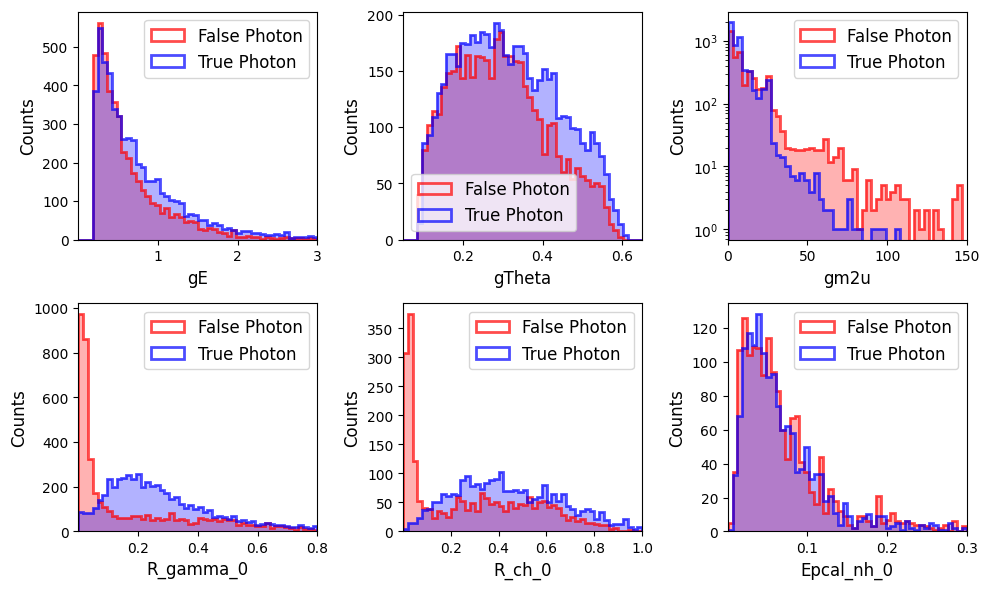

In [7]:
# Create figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Define features to plot, along with their xlimits
features = ['gE', 'gTheta', 'gm2u', 'R_gamma_0', 'R_ch_0', 'Epcal_nh_0']
xlims = [(0.001, 3), (0.05, 0.65), (0, 150), (0.001, 0.8), (0.001, 1), (0.001, 0.3)]

# Loop over all subplots
for i, ax in enumerate(axes.flat):
    feature = features[i]
    x_min = xlims[i][0]
    x_max = xlims[i][1]

    # Plot pretty histograms
    ax.hist(df[df['y'] == 0][feature], bins=50, range=(x_min,x_max), histtype='step', linewidth=2, color='red', alpha=0.7, label='False Photon')
    ax.hist(df[df['y'] == 0][feature], bins=50, range=(x_min,x_max), color='red', alpha=0.3)
    ax.hist(df[df['y'] == 1][feature], bins=50, range=(x_min,x_max), histtype='step', linewidth=2, color='blue', alpha=0.7, label='True Photon')
    ax.hist(df[df['y'] == 1][feature], bins=50, range=(x_min,x_max), color='blue', alpha=0.3)

    # Format axes
    ax.set_xlabel(feature, fontsize=12)
    ax.set_ylabel('Counts', fontsize=12)
    ax.set_xlim(x_min, x_max)
    if feature == 'gm2u':
      ax.set_yscale('log')
    ax.tick_params(axis='both', which='major', labelsize=10)

    # Create legend
    ax.legend(fontsize=12)

# Plot
plt.tight_layout()
plt.show()

Above, we observe several variables, such as the angular separation of a photon and its nearest neighbor, have strong discriminating power. Others, such as the PCal energy of its nearest neutron neighbor, do not.

The false photon problem is not as complex as it may seem. It would appear we could even place hard cuts on variables like `R_gamma_0` to separate True and False photons. However, we could do even better with an AI model.

## Impact on $\pi^0$ mass

In $\pi^0$ studies, we try to create $\pi^0$'s for each event by combining two photons and calculating their invariant mass. For $N$ photons in an event, this calculation creates $C(N,2)=N(N-1)/2$ $\pi^0$'s. To illustrate the impact of false photons on $\pi^0$ reconstruction, we define what "true" $\pi^0$'s are, and their three different types of background.



1.   **True $\pi^0$** - A reconstructed diphoton pair where each photon in the pair orignated from the same $\pi^0$ decay.
2.   **Bkg Type A $\pi^0$** - A reconstructed diphoton pair where each photon in the pair originated from different $\pi^0$ decays (ex: events where two $\pi^0$'s are produced).
3.   **Bkg Type B $\pi^0$** - A reconstructed diphoton pair where one photon is false, and the other originated from a $\pi^0$ decay.
4.   **Bkg Type C $\pi^0$** - A reconstructed diphoton pair where both photons are false.

In practice, our goal is to minimize Type B and Type C backgrounds. Type A background is "ok" since it corresponds to actual combinatoric backgrounds in our experiment. It is entirely plausible for two random true photons in an event to happen upon an invariant mass near the $\pi^0$ mass. By minimizing Type B and Type C, we reduce the *false* combinatoric background.


---


In the code below, we loop over each event and extract $\pi^0$'s using the `gE`, `gTheta` and `gPhi` of the photons in the event. We plot the invariant mass distribution with lines representing the different $\pi^0$ types above.



In [9]:
# =============================================================================
# Step 1: Define a function to compute the 4-vector for a photon
# =============================================================================
def get_4vector(gE, gTheta, gPhi):
    """
    Given a photon's energy (gE), polar angle (gTheta), and azimuthal angle (gPhi),
    calculate its momentum components (px, py, pz) and energy (E).
    """
    px = gE * np.sin(gTheta) * np.cos(gPhi)
    py = gE * np.sin(gTheta) * np.sin(gPhi)
    pz = gE * np.cos(gTheta)
    E  = gE  # For a photon, E is equal to gE (ignoring mass)
    return px, py, pz, E

# =============================================================================
# Step 2: Loop over all events to compute invariant masses for different categories
# =============================================================================
# Lists to store computed invariant masses:
all_pi0_masses   = []  # All photon pairs (total)
subset2_masses   = []  # Both photons: trueparentpid==111 and same trueparentid
subset3_masses   = []  # Both photons: trueparentpid==111 but different trueparentid
subset4_masses   = []  # One photon: trueparentpid==111 and one: trueparentpid==-999
subset5_masses   = []  # Both photons: trueparentpid==-999

# Get unique event numbers from the DataFrame
events = df['event'].unique()

# Loop over each event
for event_num in events:
    # Filter rows corresponding to the current event
    event_photons = df[df['event'] == event_num]

    # Only consider events with at least two photons
    if len(event_photons) >= 2:
        # Iterate over all unique combinations of two photons in the event
        for photon1, photon2 in itertools.combinations(event_photons.index, 2):
            # Retrieve the data rows for each photon
            row1 = event_photons.loc[photon1]
            row2 = event_photons.loc[photon2]

            # Extract kinematic variables: energy and angles
            gE1, gTheta1, gPhi1 = row1[['gE', 'gTheta', 'gPhi']]
            gE2, gTheta2, gPhi2 = row2[['gE', 'gTheta', 'gPhi']]

            # Compute the 4-vectors for both photons
            px1, py1, pz1, E1 = get_4vector(gE1, gTheta1, gPhi1)
            px2, py2, pz2, E2 = get_4vector(gE2, gTheta2, gPhi2)

            # Sum the momentum and energy to get the total 4-momentum of the pair
            total_px = px1 + px2
            total_py = py1 + py2
            total_pz = pz1 + pz2
            total_E  = E1 + E2

            # Calculate the invariant mass (pi0 candidate mass)
            pi0_mass = np.sqrt(total_E**2 - (total_px**2 + total_py**2 + total_pz**2))
            all_pi0_masses.append(pi0_mass)

            # Extract true parent identifiers for both photons
            tp1 = row1['trueparentpid']
            tp2 = row2['trueparentpid']
            id1 = row1['trueparentid']
            id2 = row2['trueparentid']

            # Categorize the photon pair based on the true parent properties
            # Subset 2: Both photons have trueparentpid==111 and the same trueparentid
            if tp1 == 111 and tp2 == 111 and id1 == id2:
                subset2_masses.append(pi0_mass)
            # Subset 3: Both photons have trueparentpid==111 but different trueparentid
            elif tp1 == 111 and tp2 == 111 and id1 != id2:
                subset3_masses.append(pi0_mass)
            # Subset 4: One photon has trueparentpid==111 and the other has trueparentpid==-999
            elif (tp1 == 111 and tp2 == -999) or (tp1 == -999 and tp2 == 111):
                subset4_masses.append(pi0_mass)
            # Subset 5: Both photons have trueparentpid==-999
            elif tp1 == -999 and tp2 == -999:
                subset5_masses.append(pi0_mass)


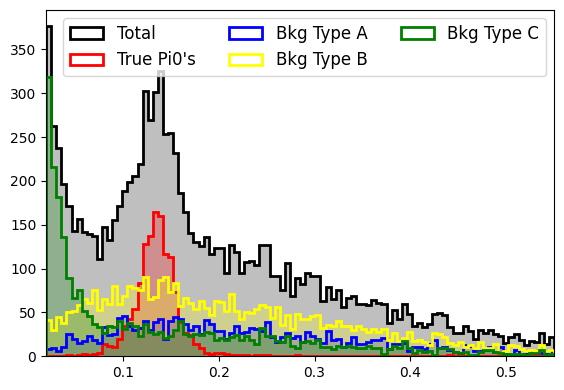

In [23]:
# Define xlimits
xlimits = (0.02,0.55)

# Define bin numbers
bins = 100

# Create figure
fig, axs = plt.subplots(1, 1, figsize=(6,4))


# Plot histograms
axs.hist(all_pi0_masses, range=xlimits, bins=bins, color="black",alpha=0.25)
axs.hist(all_pi0_masses, range=xlimits, bins=bins, color="black",histtype='step',linewidth=2, label="Total")

axs.hist(subset2_masses, range=xlimits, bins=bins, color="red",alpha=0.25)
axs.hist(subset2_masses, range=xlimits, bins=bins, color="red",histtype='step',linewidth=2, label="True Pi0's")

axs.hist(subset3_masses, range=xlimits, bins=bins, color="blue",alpha=0.25)
axs.hist(subset3_masses, range=xlimits, bins=bins, color="blue",histtype='step',linewidth=2, label="Bkg Type A")

axs.hist(subset4_masses, range=xlimits, bins=bins, color="yellow",alpha=0.25)
axs.hist(subset4_masses, range=xlimits, bins=bins, color="yellow",histtype='step',linewidth=2, label="Bkg Type B")

axs.hist(subset5_masses, range=xlimits, bins=bins, color="green",alpha=0.25)
axs.hist(subset5_masses, range=xlimits, bins=bins, color="green",histtype='step',linewidth=2, label="Bkg Type C")

# Modify axes
axs.set_xlim(xlimits)


# Plot it
axs.legend(fontsize=12,ncols=3)
plt.tight_layout()
plt.show()

In the figure above, we see that a quite a substantial amount of $\pi^0$'s that are reconstructed are of **Bkg Types B,C**. These backgrounds consist of false photons. With perfect reconstruction, the only components of the total mass spectrum would be "true Pi0's" and "Bkg Type A".

## Machine Learning

In [35]:
# We install `catboost` which is an open source library for performing gradient boosting on decision trees. You can read more about it here: https://catboost.ai/
!pip install catboost
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Set parameters for the CatBoost model
params = {
    "iterations": 500,         # Number of iterations (epochs)
    "depth": 4,                # Tree depth
    "learning_rate": 0.1,
    "loss_function": "Logloss",  # For binary classification
    "random_state": 42,
    "verbose": 1             # Controls logging frequency
}

# Initialize and train the CatBoost model with early stopping
model = CatBoostClassifier(**params)
model.fit(X_train, y_train.values.ravel(), eval_set=(X_test, y_test),
          early_stopping_rounds=50)

0:	learn: 0.6495327	test: 0.6514955	best: 0.6514955 (0)	total: 14.8ms	remaining: 7.36s
1:	learn: 0.6129042	test: 0.6175620	best: 0.6175620 (1)	total: 33.2ms	remaining: 8.26s
2:	learn: 0.5841479	test: 0.5908802	best: 0.5908802 (2)	total: 47ms	remaining: 7.79s
3:	learn: 0.5629381	test: 0.5719573	best: 0.5719573 (3)	total: 63ms	remaining: 7.81s
4:	learn: 0.5432964	test: 0.5537007	best: 0.5537007 (4)	total: 82.7ms	remaining: 8.19s
5:	learn: 0.5273778	test: 0.5387017	best: 0.5387017 (5)	total: 97.8ms	remaining: 8.05s
6:	learn: 0.5167213	test: 0.5286866	best: 0.5286866 (6)	total: 118ms	remaining: 8.29s
7:	learn: 0.5069566	test: 0.5194796	best: 0.5194796 (7)	total: 134ms	remaining: 8.23s
8:	learn: 0.4943770	test: 0.5083405	best: 0.5083405 (8)	total: 150ms	remaining: 8.18s
9:	learn: 0.4860496	test: 0.5006715	best: 0.5006715 (9)	total: 166ms	remaining: 8.15s
10:	learn: 0.4799239	test: 0.4948552	best: 0.4948552 (10)	total: 180ms	remaining: 8.02s
11:	learn: 0.4706864	test: 0.4843946	best: 0.48439

Test Accuracy: 86.05%
              precision    recall  f1-score   support

           0       0.88      0.81      0.84       917
           1       0.85      0.91      0.88      1083

    accuracy                           0.86      2000
   macro avg       0.86      0.86      0.86      2000
weighted avg       0.86      0.86      0.86      2000



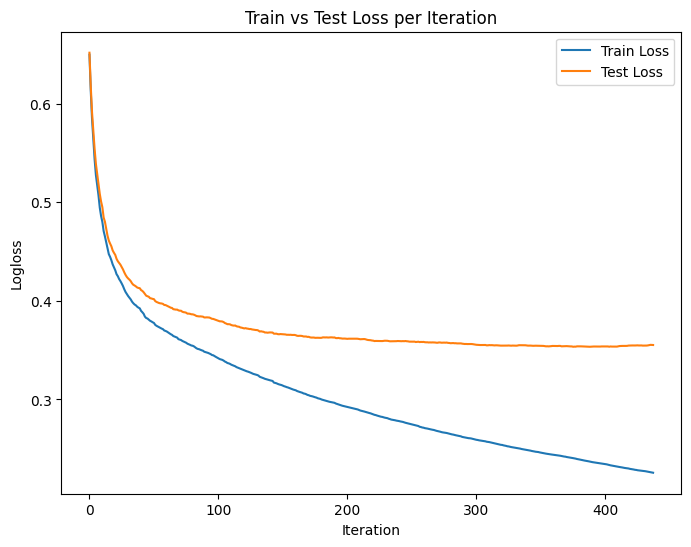

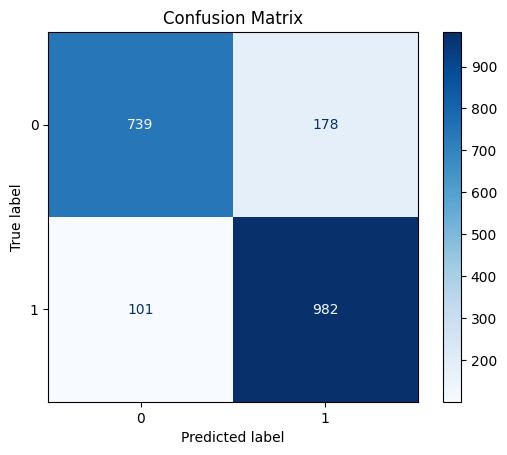

In [36]:
# Make predictions and evaluate the model
y_pred = model.predict(X_test)
print("Test Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print(classification_report(y_test, y_pred))

# Retrieve evaluation results to plot loss per iteration
evals_result = model.get_evals_result()
train_loss = evals_result['learn']['Logloss']
test_loss = evals_result['validation']['Logloss']

# Plot train and test loss per iteration
plt.figure(figsize=(8, 6))
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.xlabel('Iteration')
plt.ylabel('Logloss')
plt.title('Train vs Test Loss per Iteration')
plt.legend()
plt.show()

# Plot the confusion matrix for the test set
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()